In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotting
from sklearn.metrics import accuracy_score
import numpy as np
import sys

seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

import os
#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']


2025-06-02 21:37:00.171620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Open training and testing data

In [2]:
waveform_data = np.load("waveform_data_0.npy")
X = waveform_data[:, 4:] # 100 data points
#y = waveform_data[:, 0:4] # 4 truth labels (mean, sigma, height, pedestal)
y = waveform_data[:, [2,3]] # 2 truth labels (height, pedestal)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Take a look at the data

In [3]:
print(waveform_data.shape)
print(waveform_data)

(10000, 104)
[[ 45.77531815   8.48169518 436.07510376 ... 366.         360.
  364.        ]
 [ 49.89034271   4.14777613 366.75213623 ... 395.         453.
  408.        ]
 [ 36.79280853   7.2681036  290.6338501  ... 318.         310.
  254.        ]
 ...
 [ 34.10929108   5.1194849  184.78193665 ... 296.         268.
  231.        ]
 [ 39.16600037   6.30589771 255.33976746 ... 157.         153.
  109.        ]
 [ 58.17848969   7.28236723 460.0456543  ... 208.         213.
  186.        ]]


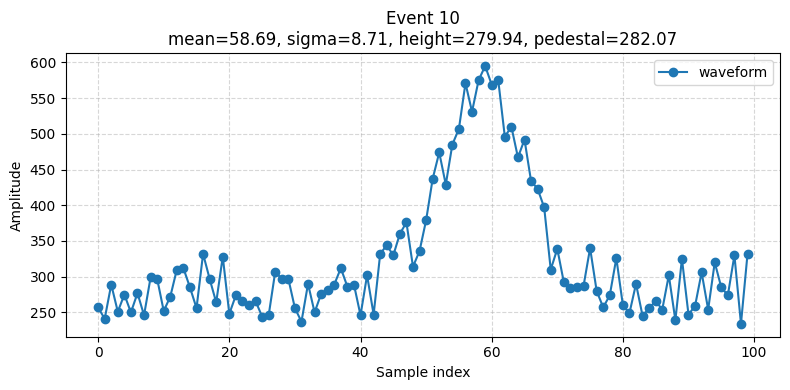

In [4]:
import matplotlib.pyplot as plt

event_id = 10 
event = waveform_data[event_id]     # shape: (104,)
truth = event[:4]                   # [mean, sigma, height, pedestal]
waveform = event[4:]                # digitized waveform

plt.figure(figsize=(8, 4))
plt.plot(waveform, marker='o', linestyle='-', label='waveform')
plt.title(f"Event {event_id}\nmean={truth[0]:.2f}, sigma={truth[1]:.2f}, height={truth[2]:.2f}, pedestal={truth[3]:.2f}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Build model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(16, input_shape=(100,), name='fc1',
                kernel_initializer='lecun_uniform',
                kernel_regularizer=l1(0.0001)))
model.add(Activation('relu'))

model.add(Dense(32, name='fc2',
                kernel_initializer='lecun_uniform',
                kernel_regularizer=l1(0.0001)))
model.add(Activation('relu'))

model.add(Dense(32, name='fc3',
                kernel_initializer='lecun_uniform',
                kernel_regularizer=l1(0.0001)))
model.add(Activation('relu'))

#model.add(Dense(4, name='output',
model.add(Dense(2, name='output',
                kernel_initializer='lecun_uniform',
                kernel_regularizer=l1(0.0001)))
model.add(Activation('linear'))  

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                1616      
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                544       
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 output (Dense)              (None, 2)                 6

2025-06-02 21:37:11.742745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Do training and save the result when the "Train" flag is true
# Or it will take the previous trained result

In [6]:
from callbacks import all_callbacks

train = True

if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse', metrics=['mse'])

    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=1e-6,
        lr_cooldown=2,
        lr_minimum=1e-7,
        outputDir='my_model_1',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )

else:
    from tensorflow.keras.models import load_model
    model = load_model('my_model_1/KERAS_check_best_model.keras')


Epoch 1/10
58/94 [=================>............] - ETA: 0s - loss: 74489.5000 - mse: 74489.4688    
***callbacks***
saving losses to my_model_1/losses.log

Epoch 1: val_loss improved from inf to 21169.69336, saving model to my_model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 21169.69336, saving model to my_model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to my_model_1/KERAS_check_model_last.h5

Epoch 1: saving model to my_model_1/KERAS_check_model_last_weights.h5

***callbacks end***

94/94 [==============================] - 1s 3ms/step - loss: 58629.8008 - mse: 58629.7656 - val_loss: 21169.6934 - val_mse: 21169.6562 - lr: 1.0000e-04
Epoch 2/10
68/94 [====================>.........] - ETA: 0s - loss: 15096.7061 - mse: 15096.6670
***callbacks***
saving losses to my_model_1/losses.log

Epoch 2: val_loss improved from 21169.69336 to 12455.34473, saving model to my_model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 21169.69336 to 12

# Process the testing sample

63/63 [==============================] - 0s 525us/step


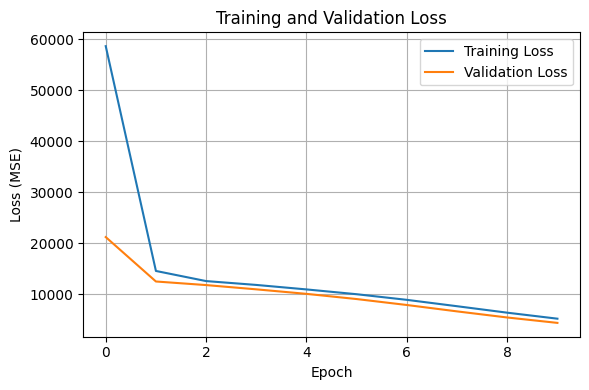

In [7]:
y_keras = model.predict(X_test)

loss = history.history['loss']
val_loss = history.history.get('val_loss')  

plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the testing result and compraing to the expected label

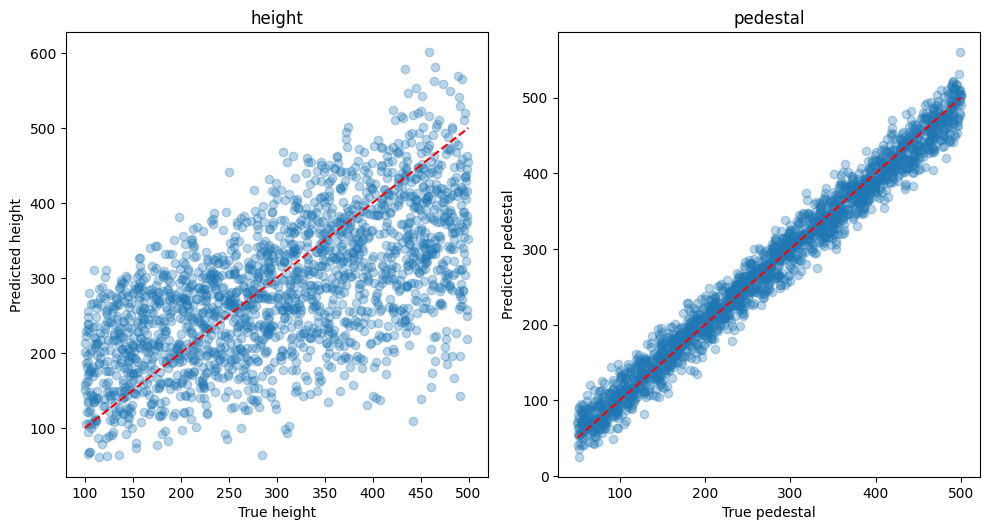

In [8]:
#labels = ["mean", "sigma", "height", "pedestal"]
labels = ["height", "pedestal"]
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test[:, i], y_keras[:, i], alpha=0.3)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()],
             'r--')
    plt.xlabel("True " + labels[i])
    plt.ylabel("Predicted " + labels[i])
    plt.title(labels[i])
plt.tight_layout()
plt.show()

# Build hls4ml model

In [9]:
import csv
import hls4ml
from hls4ml.utils import config_from_keras_model
from hls4ml.model.profiling import numerical

os.makedirs('my_model_1', exist_ok=True)

# 100 digitized waveform
np.savetxt('my_model_1/Input.dat', X_test, delimiter=' ', fmt='%.6f')
# mean, sigma, height, pedestal
np.savetxt('my_model_1/Output.dat', y_keras, delimiter=' ', fmt='%.6f')

config = config_from_keras_model(model, granularity='model')

#config['Project'] = {
#    'Defines': ['__SYNTHESIS__']
#}

plotting.print_dict(config)

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='my_model_1/hls4ml_waveform',
    part='xc7a200tsbg484-1',  # Nexys Video のFPGA部品番号
    input_data_tb='my_model_1/Input.dat',
    output_data_tb='my_model_1/Output.dat',
    backend='Vitis'  
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: fc1, layer type: Dense, input shapes: [[None, 100]], output shape: [None, 16]
Layer name: activation, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc2, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: activation_1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: activation_2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation_3, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          La

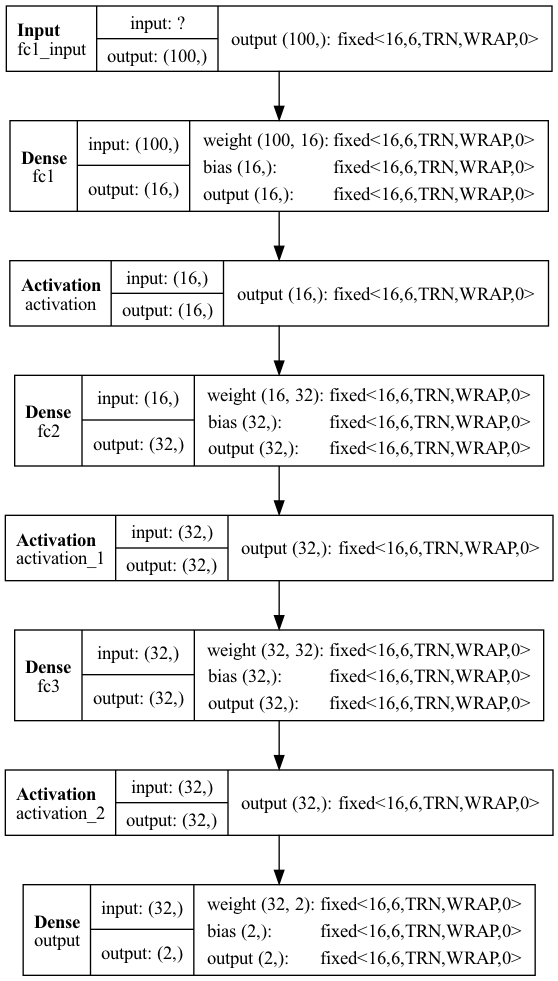

In [10]:
# This is to show the hls4ml model structure
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file='hls_model.png')
Image('hls_model.png')

In [2]:
# Compile it
hls_model.compile()

NameError: name 'hls_model' is not defined

# Process the testing data with hls4ml model and see the performance

In [1]:
from sklearn.metrics import mean_squared_error
import ctypes
hls_model._top_function_lib = ctypes.cdll.LoadLibrary('my_model_1/hls4ml_waveform/firmware/myproject.so')

y_hls = hls_model.predict(np.ascontiguousarray(X_test))

for i, name in enumerate(["height", "pedestal"]):
    mse_keras = mean_squared_error(y_test[:, i], y_keras[:, i])
    mse_hls = mean_squared_error(y_test[:, i], y_hls[:, i])
    print(f"{name}: MSE Keras = {mse_keras:.4f}, HLS = {mse_hls:.4f}")

NameError: name 'hls_model' is not defined